In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Anup
[nltk_data]     Tasin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
df = pd.read_csv('climate_nasa.csv')
df.head(15)

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."
5,2022-09-15T17:10:57.000Z,4,191055fb869d185092abf1405f0b2f4abe73bcaa9beb85...,1.0,Excellent example...very relatable to the Gen ...
6,2022-09-07T17:31:25.000Z,10,a9117191b443a0494349d21508a3de7df675250b786612...,NaN,I am so proud of whoever created this content....
7,2022-09-07T18:07:53.000Z,1,39c3ec5a079b6b1a62577a1d13d4e8f894c5525575b85d...,21.0,Has the Earth ever had a concentration of over...
8,2022-09-07T22:45:56.000Z,0,1492464caa9b6757f6e740a6cc8f75a44614645e9f6c64...,NaN,"Yes, and not even half a cup later that poor s..."
9,2022-09-07T16:30:55.000Z,4,31fd4cfea1a56eb21ad6a86ce4ed94e6a15e654b3557bf...,8.0,Historical co2 data would make it an interesti...


In [5]:
print(df.head())

                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\n ...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None


In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [9]:
df = df.dropna(subset=['date'])

In [12]:
df['likesCount'] = df['likesCount'].fillna(0)
df['commentsCount'] = df['commentsCount'].fillna(0)

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

In [15]:
df['Cleaned_Text'] = df['text'].apply(clean_text)

In [17]:
sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

print(df[['text', 'Sentiment', 'Sentiment_Label']].head())

                                                text  Sentiment  \
0  Neat comparison I have not heard it before.\n ...     0.7702   
1  An excellent way to visualise the invisible! T...     0.7650   
2  Does the CO2/ghg in the troposphere affect the...     0.2960   
3  excellent post! I defo feel the difference - o...     0.1027   
4  Yes, and carbon dioxide does not harm the Eart...     0.6059   

  Sentiment_Label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Positive  


In [18]:
sns.set(style="whitegrid")

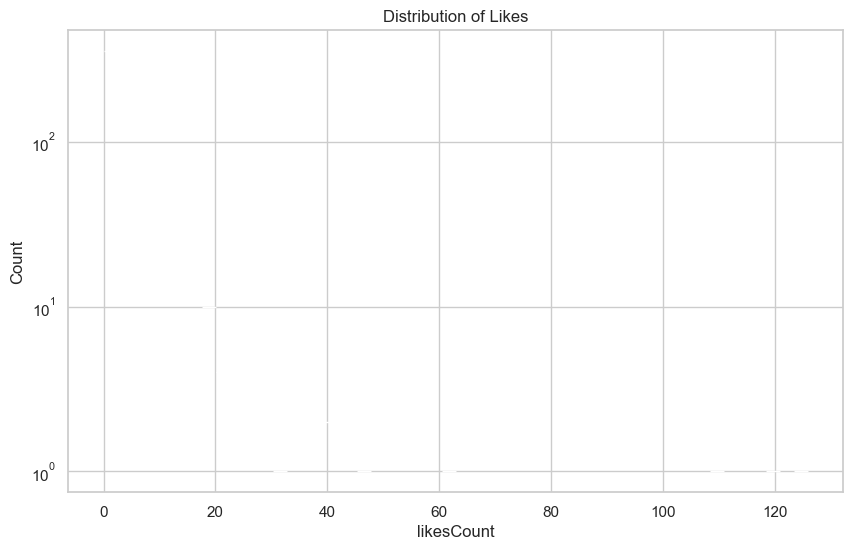

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(df['likesCount'], bins=50, log_scale=(False, True))
plt.title('Distribution of Likes')
plt.show()

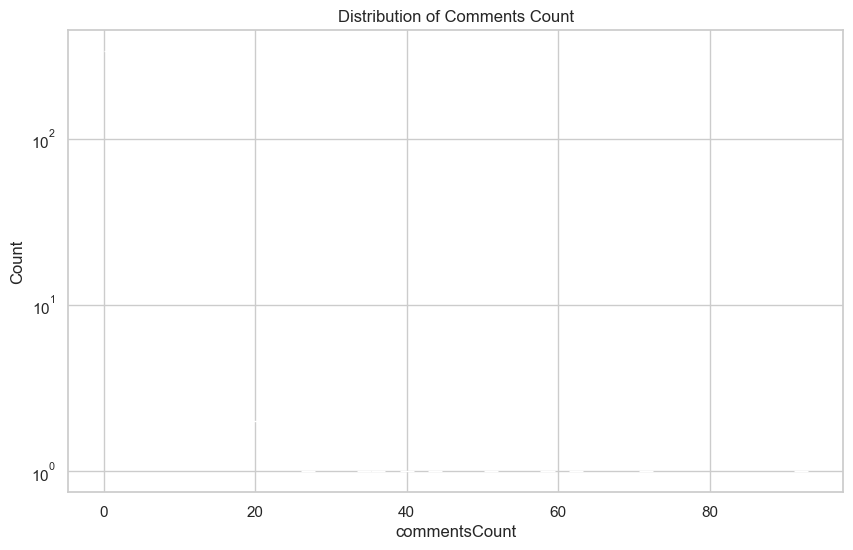

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(df['commentsCount'], bins=50, log_scale=(False, True))
plt.title('Distribution of Comments Count')
plt.show()

C:\Users\Anup Tasin\AppData\Local\Temp\ipykernel_10352\3181124337.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=df, palette='Set2')


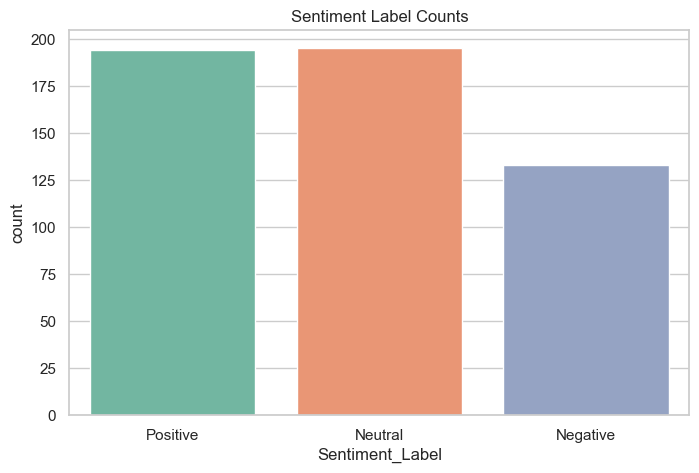

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment_Label', data=df, palette='Set2')
plt.title('Sentiment Label Counts')
plt.show()

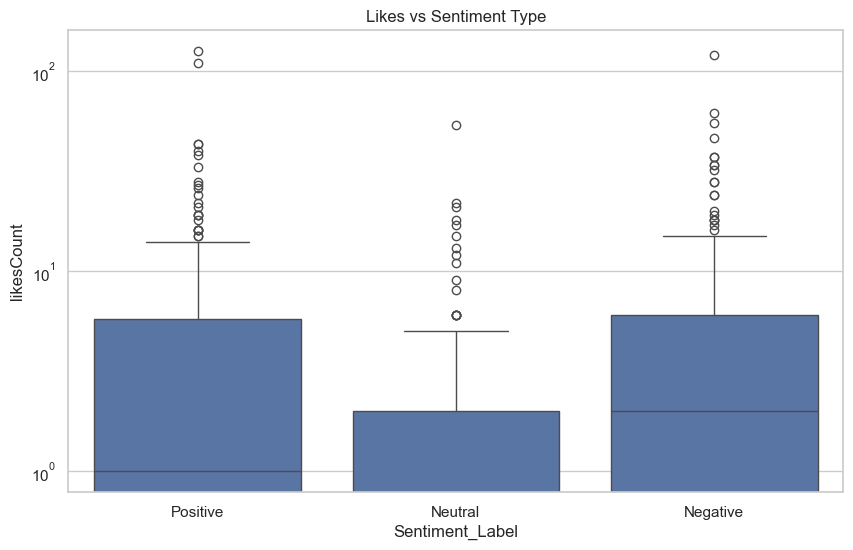

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Sentiment_Label', y='likesCount', data=df)
plt.yscale('log')
plt.title('Likes vs Sentiment Type')
plt.show()

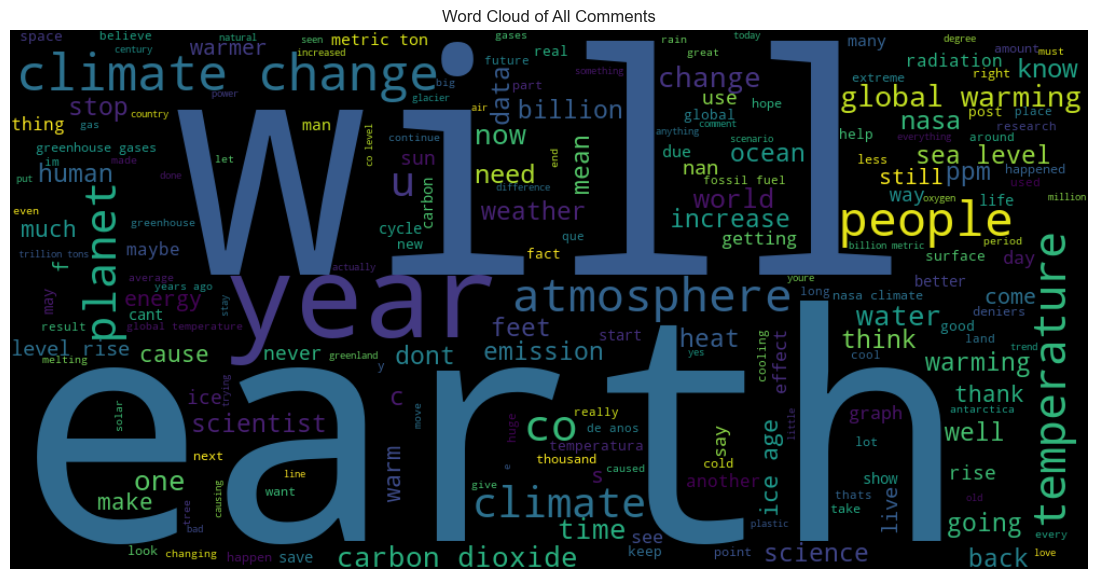

In [25]:
text = " ".join(df['Cleaned_Text'])
wordcloud = WordCloud(width=1000, height=500, background_color='black', stopwords=STOPWORDS).generate(text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Comments')
plt.show()

In [27]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)


C:\Users\Anup Tasin\AppData\Local\Temp\ipykernel_10352\2724467692.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Sentiment'].resample('M').mean().plot()


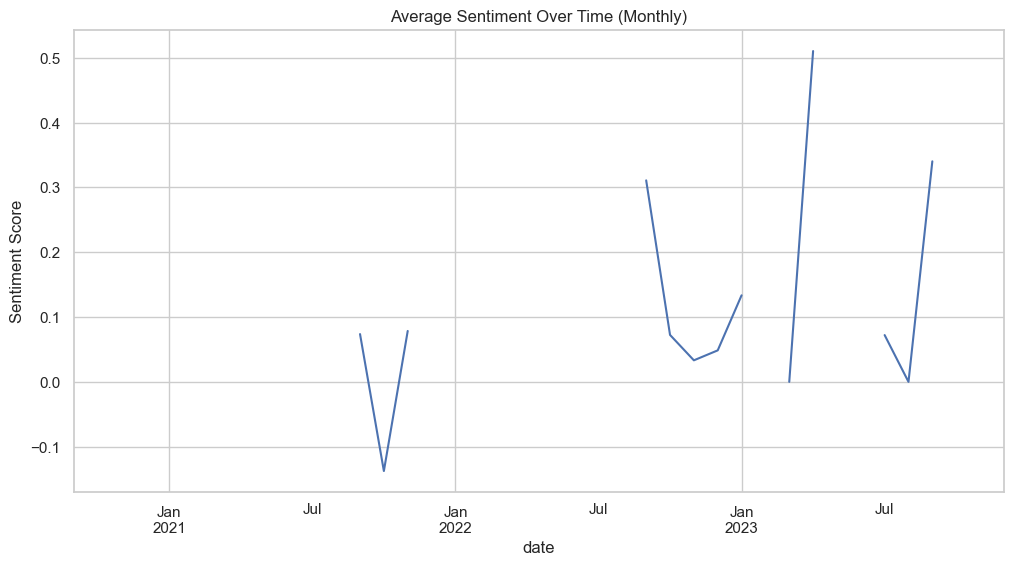

In [28]:
plt.figure(figsize=(12,6))
df['Sentiment'].resample('M').mean().plot()
plt.title('Average Sentiment Over Time (Monthly)')
plt.ylabel('Sentiment Score')
plt.show()

In [32]:
model_df = df[['likesCount', 'commentsCount', 'Sentiment']].copy()

X = model_df[['commentsCount', 'Sentiment']]
y = model_df['likesCount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Random Forest Model RMSE: {rmse:.2f}')
print(f'Random Forest Model R2: {r2:.2f}')


Random Forest Model RMSE: 8.08
Random Forest Model R2: -0.04


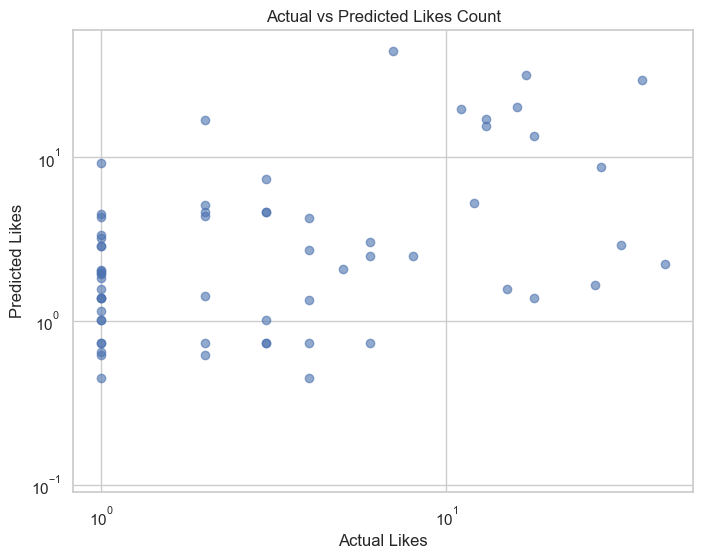

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs Predicted Likes Count')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [34]:
df.to_csv('climate_nasa_cleaned.csv')